#### Speaker Change Detection Using F0 and MFCC Features with the IEMOCAP Dataset 
 
This is a Malay word prediction assignment, where given n previous Malay words (wordi+1 , 
wordi+2, wordi+n), you are required to predict wordn+1. Train a deep learning neural network to 
perform the task using the training and validation data. Evaluate the accuracy of your model 
using the test data.

Objectives<br>
O1: Construct natural language processing and deep learning components in problems 
involving prediction, classification and sequence modeling in text and speech. <br>
O2: Design solutions using natural language processing and deep learning techniques for 
problems in text and speech analytics. 

#### 1. Understanding the Dataset
• Task: Familiarize yourself with the IEMOCAP dataset, focusing on its dialog sessions, 
speaker labels, and audio features. 

#### 2. Feature Extraction 
• Task: Extract the following features for audio segmentation: <br>
    1. Fundamental Frequency (F0): Represents the pitch. <br>
    2. MFCC Features: Capture the spectral properties of speech.<br> <br>
• Use a sliding window (e.g., 20ms frames with 10ms overlap) for feature extraction.<br> 
• Tools: Use libraries like librosa or praat-parselmouth. <br>
• Deliverable: <br>
    - Python notebook scripts for feature extraction.<br> 
    - A visualization of the extracted features for a sample audio file (e.g., plot MFCCs and F0 over time). 

In [1]:
############################################
# 1. Imports and Basic Setup
############################################

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing
import librosa
import librosa.display
import parselmouth

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve, auc,precision_recall_curve, average_precision_score, f1_score
from sklearn.svm import SVC
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Optimizer

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072)])

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


Extraction without preprocessing

c:\Users\Lee Ying Shen\.conda\envs\cpc353\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


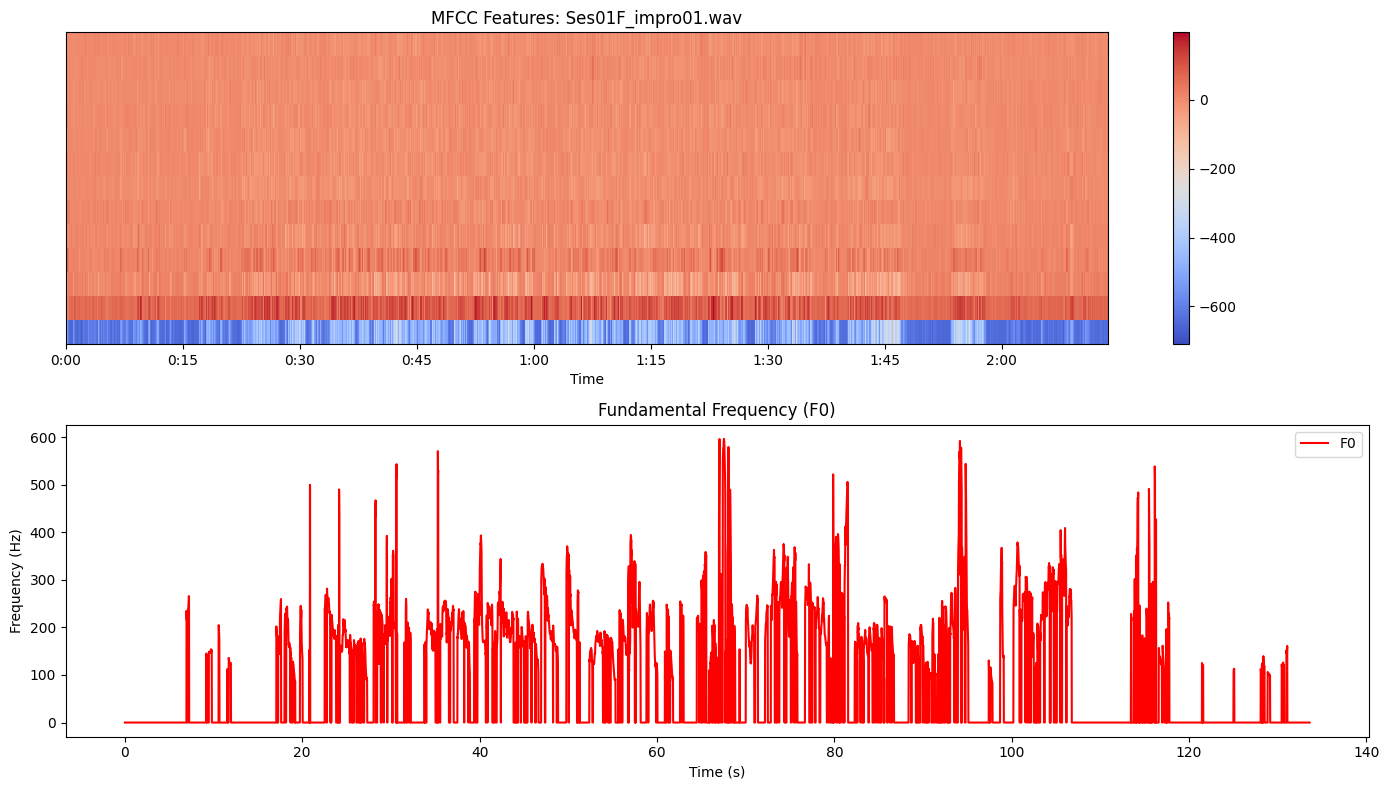

Feature extraction complete. MFCC and F0 files have been saved.


In [9]:
############################################
# 2. Feature Extraction
#    - Fundamental Frequency (F0) using parselmouth
#    - MFCC using librosa
#    - 20ms frames, 10ms overlap
############################################

# Directories (please adjust to your paths)
wav_dir = r'IEMOCAP\IEMOCAP\All_Wav_Files'
output_dir = r'IEMOCAP\IEMOCAP\features'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Frame and hop size in seconds
frame_length = 0.02  # 20 ms
hop_length = 0.01    # 10 ms

# For visualization (optional) - to only plot one file
first_wav_plotted = False

for file in os.listdir(wav_dir):
    if file.endswith('.wav'):
        file_path = os.path.join(wav_dir, file)
        
        # Load audio using librosa
        y, sr = librosa.load(file_path, sr=None)

        # Calculate frame and hop lengths in samples
        frame_size = int(frame_length * sr)
        hop_size = int(hop_length * sr)

        # 1) Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, 
                                    n_fft=frame_size, hop_length=hop_size)
        
        # 2) Extract F0 using parselmouth (Praat)
        sound = parselmouth.Sound(file_path)
        pitch = sound.to_pitch(time_step=hop_length)
        f0 = pitch.selected_array['frequency']

        # Save extracted features (as .npy)
        # The output filenames append "_mfcc.npy" and "_f0.npy"
        base_name = os.path.splitext(file)[0]
        np.save(os.path.join(output_dir, f'{base_name}_mfcc.npy'), mfcc)
        np.save(os.path.join(output_dir, f'{base_name}_f0.npy'), f0)
        
        # Visualization for the first file only
        if not first_wav_plotted:
            # Plot MFCC
            plt.figure(figsize=(14, 8))
            
            plt.subplot(2, 1, 1)
            librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=hop_size)
            plt.colorbar()
            plt.title(f'MFCC Features: {file}')

            # Plot F0
            plt.subplot(2, 1, 2)
            time_axis = np.linspace(0, len(f0) * hop_length, len(f0))
            plt.plot(time_axis, f0, color='r', label='F0')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Fundamental Frequency (F0)')
            plt.legend()

            plt.tight_layout()
            plt.show()
            
            first_wav_plotted = True

print("Feature extraction complete. MFCC and F0 files have been saved.")


Extraction with preprocessing

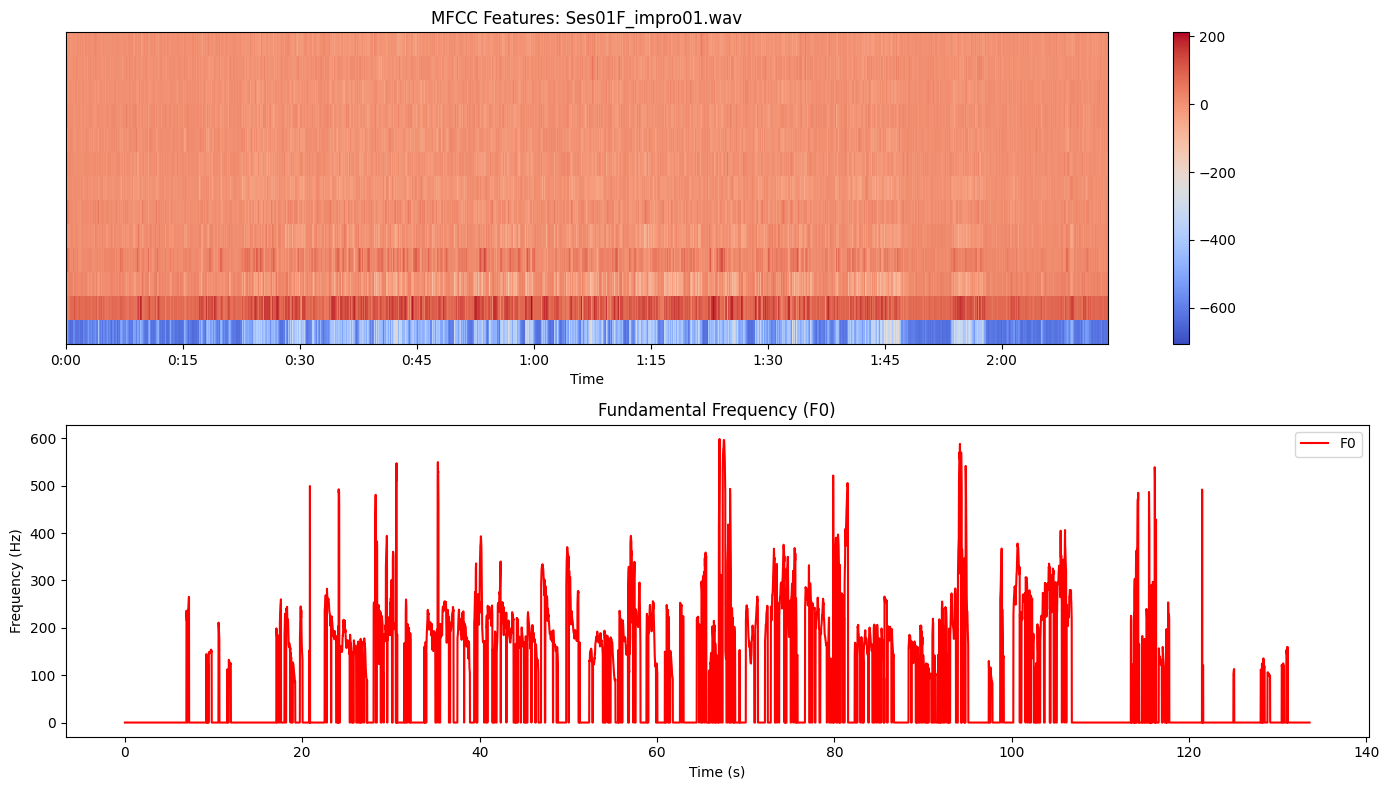

Feature extraction complete. MFCC and F0 files have been saved as CSV.


In [ ]:
############################################
# 2. Feature Extraction
#    - Fundamental Frequency (F0) using parselmouth
#    - MFCC using librosa
#    - 20ms frames, 10ms overlap
############################################

wav_dir = r'IEMOCAP\IEMOCAP\All_Wav_Files'
output_dir = r'IEMOCAP\IEMOCAP\features'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Frame and hop size in seconds
frame_length = 0.02  # 20 ms
hop_length = 0.01    # 10 ms

# to only plot one file
first_wav_plotted = False

for file in os.listdir(wav_dir):
    if file.endswith('.wav'):
        file_path = os.path.join(wav_dir, file)
        
        # Load audio using librosa
        y, sr = librosa.load(file_path, sr=None)

        # Calculate frame and hop lengths in samples
        frame_size = int(frame_length * sr)
        hop_size = int(hop_length * sr)

        # 1) Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, 
                                    n_fft=frame_size, hop_length=hop_size)
        
        # 2) Extract F0 using parselmouth (Praat)
        sound = parselmouth.Sound(file_path)
        pitch = sound.to_pitch(time_step=hop_length)
        f0 = pitch.selected_array['frequency']
        f0[np.isnan(f0)] = 0  # Handle NaN values

        # Save extracted features as CSV
        base_name = os.path.splitext(file)[0]
        feature_df = pd.DataFrame(mfcc.T, columns=[f'mfcc_{i+1}' for i in range(mfcc.shape[0])])
        feature_df['f0'] = np.interp(np.arange(len(mfcc.T)), np.arange(len(f0)), f0)
        feature_df.to_csv(os.path.join(output_dir, f'{base_name}.csv'), index=False)
        
        # Visualization for the first file only
        if not first_wav_plotted:
            plt.figure(figsize=(14, 8))
            
            plt.subplot(2, 1, 1)
            librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=hop_size)
            plt.colorbar()
            plt.title(f'MFCC Features: {file}')

            plt.subplot(2, 1, 2)
            time_axis = np.linspace(0, len(f0) * hop_length, len(f0))
            plt.plot(time_axis, f0, color='r', label='F0')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Fundamental Frequency (F0)')
            plt.legend()

            plt.tight_layout()
            plt.show()
            
            first_wav_plotted = True

print("Feature extraction complete. MFCC and F0 files have been saved as CSV.")


### 3. Data Preprocessing 
• Task: <br>
o Label data for speaker changes (binary labels: 1 for change, 0 for no change). <br>
• Divide the data into train (session 1-3), validation (session 4), and test (session 5) sets.<br> 
• Deliverable:<br> 
o A Python notebook or script detailing preprocessing steps. 

In [28]:

features_folder = r"IEMOCAP\IEMOCAP\features"
rttm_folder = r"IEMOCAP\IEMOCAP\reference"
neighborhood_ms = 150  # Neighborhood size of 250ms


def get_labels_from_rttm(rttm_file, audio_length, frame_rate):
    labels = np.zeros(int(audio_length * frame_rate))
    with open(rttm_file, 'r') as file:
        for line in file:
            parts = line.split()
            start_time = float(parts[3])
            start_frame = int(start_time * frame_rate)
            
            # Set label to 1 at start time
            labels[start_frame] = 1
            
    return labels


# Initial label assignment loop
for file in os.listdir(features_folder):
    if file.endswith('.csv'):
        print(file)
        base_name = file.replace('.csv', '')
        csv_path = os.path.join(features_folder, file)
        rttm_file = os.path.join(rttm_folder, f'{base_name}.rttm')
        
        # Read CSV file
        df = pd.read_csv(csv_path)
        # Add time in seconds
        df['time'] = np.arange(len(df)) * hop_length
        
        # Calculate audio length and frame rate
        audio_length = len(df) * hop_length
        frame_rate = 1 / hop_length
        
        # Generate speaker change labels from RTTM
        if os.path.exists(rttm_file):
            labels = get_labels_from_rttm(rttm_file, audio_length, frame_rate)
            labels = labels[:len(df)]  # Ensure label length matches the dataframe
            df['label'] = labels
        else:
            df['label'] = 0  # Default to no speaker change if RTTM is missing
        
        # Save updated CSV with initial labels
        df.to_csv(os.path.join(features_folder, file), index=False)


# Second loop to create artificial data points (neighborhood labeling)
neighborhood_frames = int(neighborhood_ms / 1000 / hop_length)

for file in os.listdir(features_folder):
    if file.endswith('.csv'):
        print(file)
        csv_path = os.path.join(features_folder, file)
        df = pd.read_csv(csv_path)
        
        # Get the frames where speaker change is detected
        change_points = np.where(df['label'] == 1)[0]
        
        # Expand the neighborhood around each change point
        for point in change_points:
            start_neigh = max(0, point - neighborhood_frames)
            end_neigh = min(len(df), point + neighborhood_frames)
            df.loc[start_neigh:end_neigh, 'label'] = 1  # Label the neighborhood as 1
        
        # Save the updated CSV with augmented labels
        df.to_csv(csv_path, index=False)

Ses01F_impro01.csv
Ses01F_impro02.csv
Ses01F_impro03.csv
Ses01F_impro04.csv
Ses01F_impro05.csv
Ses01F_impro06.csv
Ses01F_impro07.csv
Ses01F_script01_1.csv
Ses01F_script01_2.csv
Ses01F_script01_3.csv
Ses01F_script02_1.csv
Ses01F_script02_2.csv
Ses01F_script03_1.csv
Ses01F_script03_2.csv
Ses01M_impro01.csv
Ses01M_impro02.csv
Ses01M_impro03.csv
Ses01M_impro04.csv
Ses01M_impro05.csv
Ses01M_impro06.csv
Ses01M_impro07.csv
Ses01M_script01_1.csv
Ses01M_script01_2.csv
Ses01M_script01_3.csv
Ses01M_script02_1.csv
Ses01M_script02_2.csv
Ses01M_script03_1.csv
Ses01M_script03_2.csv
Ses02F_impro01.csv
Ses02F_impro02.csv
Ses02F_impro03.csv
Ses02F_impro04.csv
Ses02F_impro05.csv
Ses02F_impro06.csv
Ses02F_impro07.csv
Ses02F_impro08.csv
Ses02F_script01_1.csv
Ses02F_script01_2.csv
Ses02F_script01_3.csv
Ses02F_script02_1.csv
Ses02F_script02_2.csv
Ses02F_script03_1.csv
Ses02F_script03_2.csv
Ses02M_impro01.csv
Ses02M_impro02.csv
Ses02M_impro03.csv
Ses02M_impro04.csv
Ses02M_impro05.csv
Ses02M_impro06.csv
Ses02M

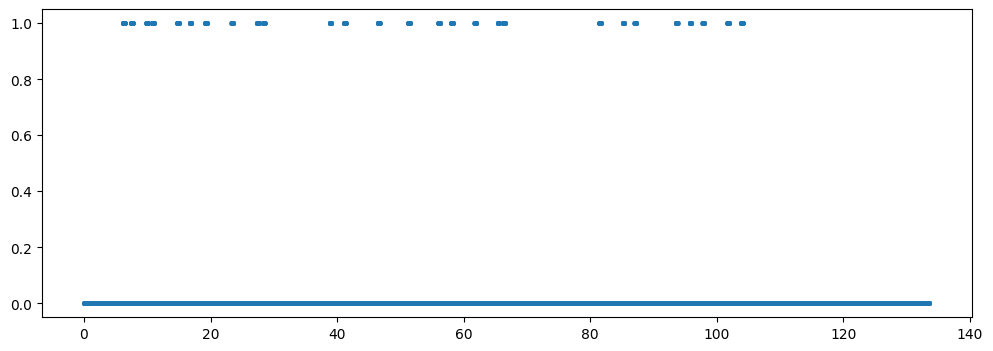

Total counts per class:
label
0.0    2600624.0
1.0     176907.0
dtype: float64

Percentages:
label
0.0    93.630782
1.0     6.369218
dtype: float64


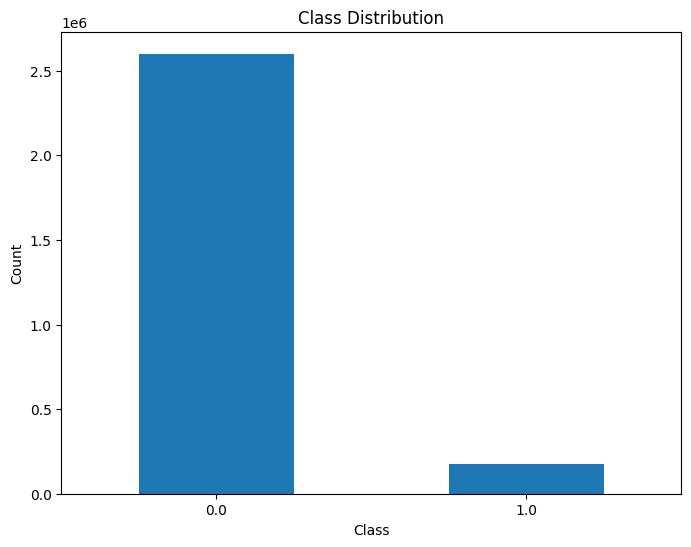

In [29]:
df = pd.read_csv(os.path.join(features_folder, 'Ses01F_impro01.csv'))
# Visualization of speaker change labels
plt.figure(figsize=(12, 4))
plt.scatter(df['time'],df['label'],s=6)
plt.show()

# Load and count labels from all CSV files in the features folder
total_counts = pd.Series(dtype=int)

for file in os.listdir(features_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(features_folder, file))
        counts = df['label'].value_counts()
        total_counts = total_counts.add(counts, fill_value=0)

# Display the counts and percentages
print("Total counts per class:")
print(total_counts)
print("\nPercentages:")
print(total_counts / total_counts.sum() * 100)

# Visualize the class distribution
plt.figure(figsize=(8, 6))
total_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 4. Model Development 
• Task: <br>
o Train a machine learning model to classify speaker changes. <br>
o Experiment with different window sizes or time-lagged parameters for better 
performance. <br>
o Evaluate performance using metrics such as F1-score, precision, and recall.<br> 
• Deliverable: <br>
o Model training scripts.<br> 
o A summary of model architecture and parameters.<br> 
o Plots showing training and validation accuracy/loss curves.<br> 

### LSTM 

In [11]:
# Data preparation
features_folder = r"IEMOCAP\IEMOCAP\features"
files = os.listdir(features_folder)

train_files = [f for f in files if "Ses01" in f or "Ses02" in f or "Ses03" in f]
val_files = [f for f in files if "Ses04" in f]
test_files = [f for f in files if "Ses05" in f]

def load_data(file_list):
    data = []
    for file in file_list:
        path = os.path.join(features_folder, file)
        df = pd.read_csv(path)
        data.append(df)
    return pd.concat(data, axis=0)

# Fixed sequence length
sequence_length = 100

def prepare_data():
    train_data = load_data(train_files)
    val_data = load_data(val_files)
    test_data = load_data(test_files)

    feature_cols = [col for col in train_data.columns if col.startswith('mfcc') or col == 'f0']

    # Scale features
    scaler = StandardScaler()
    train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
    val_data[feature_cols] = scaler.transform(val_data[feature_cols])
    test_data[feature_cols] = scaler.transform(test_data[feature_cols])

    # Additional normalization
    scaler = MinMaxScaler()
    train_data[feature_cols] = scaler.fit_transform(train_data[feature_cols])
    val_data[feature_cols] = scaler.transform(val_data[feature_cols])
    test_data[feature_cols] = scaler.transform(test_data[feature_cols])

    # Prepare sequences
    X_train = train_data[feature_cols].values
    X_val = val_data[feature_cols].values
    X_test = test_data[feature_cols].values
    y_train = train_data['label'].values
    y_val = val_data['label'].values
    y_test = test_data['label'].values

    # Calculate sizes that are divisible by sequence_length
    train_size = (len(X_train) // sequence_length) * sequence_length
    val_size = (len(X_val) // sequence_length) * sequence_length
    test_size = (len(X_test) // sequence_length) * sequence_length

    # Truncate arrays to be divisible by sequence_length
    X_train = X_train[:train_size]
    X_val = X_val[:val_size]
    X_test = X_test[:test_size]
    y_train = y_train[:train_size]
    y_val = y_val[:val_size]
    y_test = y_test[:test_size]

    # Reshape data into sequences
    X_train_seq = X_train.reshape(-1, sequence_length, len(feature_cols))
    X_val_seq = X_val.reshape(-1, sequence_length, len(feature_cols))
    X_test_seq = X_test.reshape(-1, sequence_length, len(feature_cols))

    y_train_seq = y_train.reshape(-1, sequence_length, 1)
    y_val_seq = y_val.reshape(-1, sequence_length, 1)
    y_test_seq = y_test.reshape(-1, sequence_length, 1)

    # Print shapes for verification
    print("Training shapes:", X_train_seq.shape, y_train_seq.shape)
    print("Validation shapes:", X_val_seq.shape, y_val_seq.shape)
    print("Testing shapes:", X_test_seq.shape, y_test_seq.shape)

    return X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, feature_cols

# Model creation and training
def create_model(input_shape):
    # Define L2 regularizer
    l2_reg = tf.keras.regularizers.l2(1e-4)
    
    model = models.Sequential([
        # First Bidirectional LSTM layer
        layers.Bidirectional(
            layers.LSTM(64, return_sequences=True, 
                       kernel_regularizer=l2_reg),
            input_shape=input_shape
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Second Bidirectional LSTM layer
        layers.Bidirectional(
            layers.LSTM(40, return_sequences=True,
                       kernel_regularizer=l2_reg)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Dense layers with batch normalization
        layers.Dense(40, activation='relu',
                    kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        
        layers.Dense(10, activation='relu',
                    kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Prepare data
X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, feature_cols = prepare_data()

# Create and train model
model = create_model((sequence_length, len(feature_cols)))

tf.keras.utils.plot_model(model, show_shapes=True)
print(model.summary())

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=700,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save('speaker_change_detection_model.h5')

Training shapes: (16351, 100, 1) (16351, 100, 1)
Validation shapes: (5561, 100, 1) (5561, 100, 1)
Testing shapes: (5862, 100, 1) (5862, 100, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 100, 128)         33792     
 nal)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 100, 128)         512       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 100, 128)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 100, 80)          54080     
 nal)                                                            
                                          

KeyboardInterrupt: 

Plot the Training History

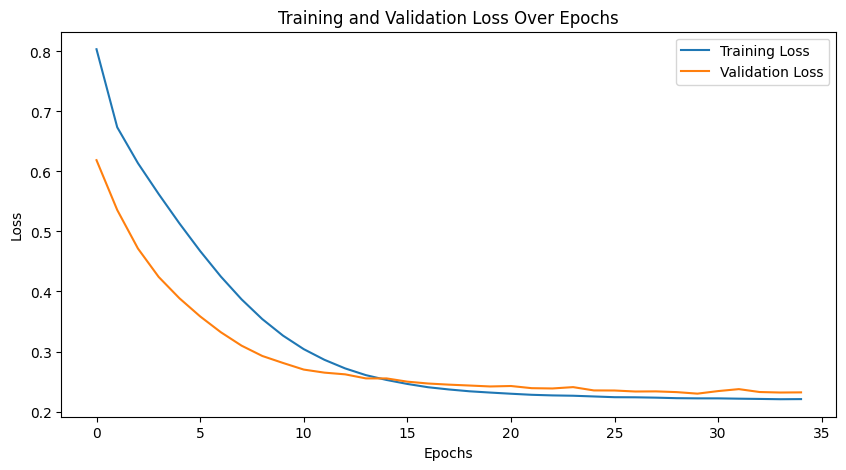

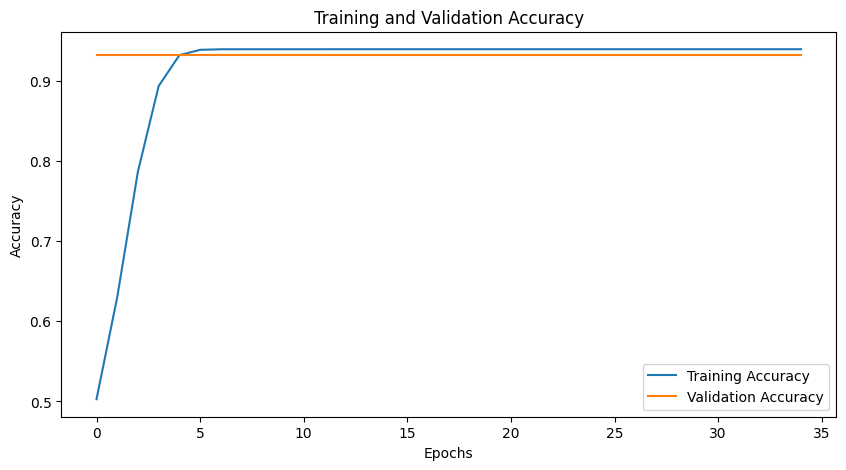

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### 5. Results and Discussion 
• Task: <br>
o Test the model on unseen data.<br> 
o Analyze the model with different window sizes and time-lagged parameters.<br> 
o Analyze model performance at detecting speaker change points, discussing
strengths and weaknesses. <br>
• Deliverable: <br>
o A brief report discussing results and suggestions for improvement. <br>

In [14]:
def compute_purity_coverage(reference, hypothesis):
    """
    Compute purity and coverage for speaker change detection.

    Parameters:
    - reference: list of tuples (start, end) for ground truth segments
    - hypothesis: list of tuples (start, end) for detected segments
    
    Returns:
    - purity: alignment between hypothesis and reference
    - coverage: how much of the reference is covered by hypothesis
    """
    
    def intersection(segment1, segment2):
        return max(0, min(segment1[1], segment2[1]) - max(segment1[0], segment2[0]))

    if not hypothesis:  # Handle empty hypothesis case
        return 0.0, 0.0
    
    # Compute coverage
    coverage_sum = sum(max(intersection(r, h) for h in hypothesis) for r in reference)
    coverage = coverage_sum / sum((r[1] - r[0]) for r in reference)
    
    # Compute purity
    purity_sum = sum(max(intersection(h, r) for r in reference) for h in hypothesis)
    purity = purity_sum / sum((h[1] - h[0]) for h in hypothesis)
    
    return purity, coverage

def extract_segments(predictions, threshold=0.5):
    """
    Extract continuous segments from frame-level predictions.
    """
    segments = []
    start = None
    for i, pred in enumerate(predictions):
        if pred > threshold and start is None:
            start = i
        elif pred <= threshold and start is not None:
            segments.append((start, i))
            start = None
    if start is not None:
        segments.append((start, len(predictions)))
    return segments

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true.flatten(), y_pred.flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true.flatten(), y_pred.flatten())
    avg_precision = average_precision_score(y_true.flatten(), y_pred.flatten())

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

def plot_predictions(y_true, y_pred, segment_length=1000):
    plt.figure(figsize=(15, 5))
    plt.plot(y_true[:segment_length], label='Ground Truth', linestyle='dashed')
    plt.plot(y_pred[:segment_length], label='Predictions')
    plt.xlabel('Time (frames)')
    plt.ylabel('Speaker Change (0 or 1)')
    plt.title('Speaker Change Detection - Ground Truth vs Predictions')
    plt.legend()
    plt.show()

def tune_threshold(y_true, y_pred_probs, metric=f1_score, plot=True):
    """
    Tune the threshold (θ) for speaker change detection by maximizing the chosen metric.

    Parameters:
    - y_true: Ground truth binary labels (flattened).
    - y_pred_probs: Predicted probabilities (flattened).
    - metric: Metric to optimize (default: F1-score).
    - plot: Whether to plot the metric vs. threshold curve.

    Returns:
    - best_theta: Optimal threshold (θ) that maximizes the metric.
    - best_score: The highest metric score.
    - theta_values: List of thresholds tested.
    - scores: Corresponding metric scores for each threshold.
    """

    theta_values = np.linspace(0, 1, 100)
    scores = []

    for theta in theta_values:
        y_pred = (y_pred_probs > theta).astype(int)
        score = metric(y_true, y_pred)
        scores.append(score)

    # Get the best threshold
    best_theta = theta_values[np.argmax(scores)]
    best_score = max(scores)

    # Plot the results if requested
    if plot:
        plt.figure()
        plt.plot(theta_values, scores)
        plt.xlabel('Threshold (θ)')
        plt.ylabel(f'{metric.__name__}')
        plt.title(f'Threshold (θ) Tuning for {metric.__name__}')
        plt.show()

    print(f"Optimal θ: {best_theta:.2f} (Max {metric.__name__}: {best_score:.2f})")
    return best_theta, best_score, theta_values, scores

def plot_confusion_matrix(y_actual, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_actual, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


#### Tune for the best threshold

184/184 [==============================] - 4s 16ms/step


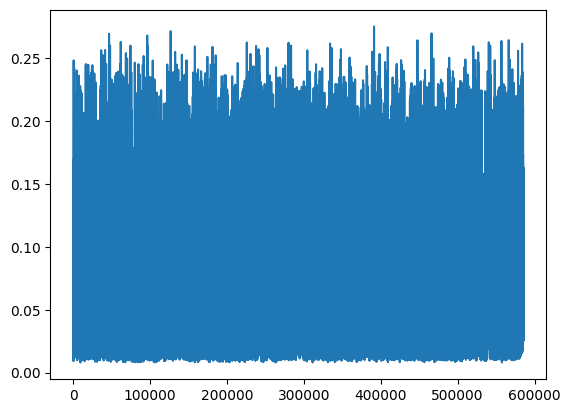

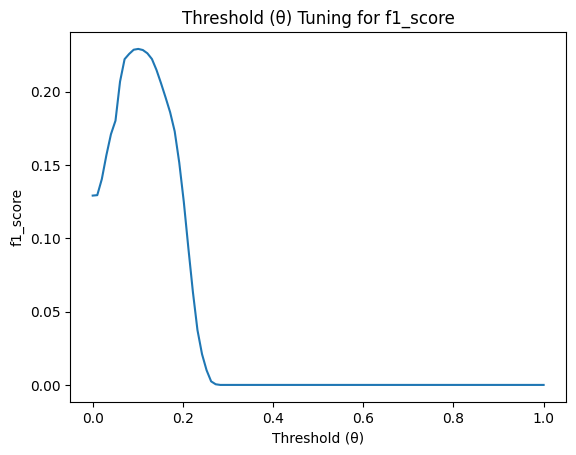

Optimal θ: 0.10 (Max f1_score: 0.23)


In [15]:
y_pred_probs = model.predict(X_test_seq).flatten()

plt.plot(y_pred_probs)

y_true_flat = y_test_seq.flatten()

# Tune threshold for F1-score
best_theta, best_f1, _, _ = tune_threshold(y_true_flat, y_pred_probs, metric=f1_score)

#### Evaluate

184/184 [==============================] - 3s 17ms/step
Purity: 0.16
Coverage: 0.38
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90    545736
         1.0       0.16      0.39      0.23     40464

    accuracy                           0.82    586200
   macro avg       0.56      0.62      0.56    586200
weighted avg       0.90      0.82      0.85    586200



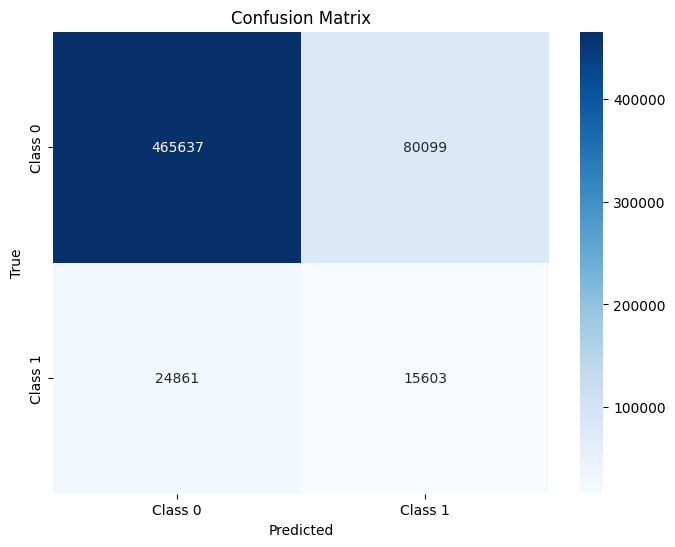

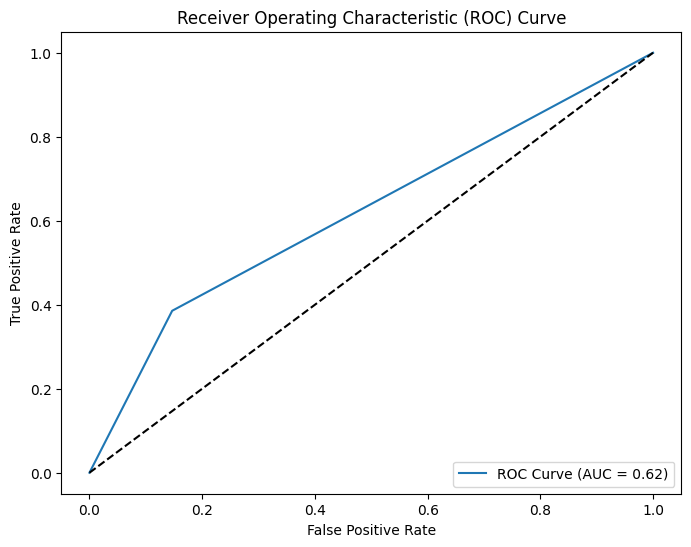

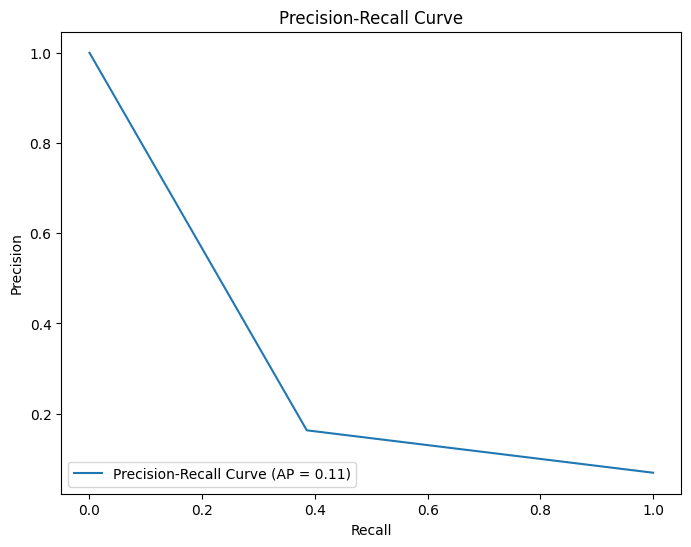

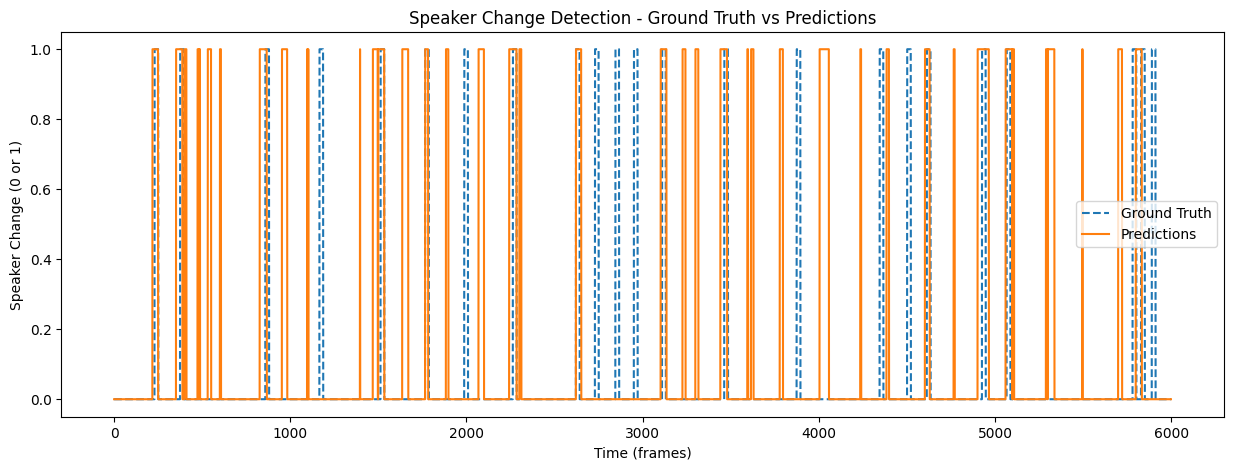

In [16]:
# Model predictions
y_pred = (model.predict(X_test_seq).flatten() > best_theta).astype(int)

# Flatten predictions and ground truth
y_pred_flat = y_pred.flatten()
y_true_flat = y_test_seq.flatten()

purity,coverage = compute_purity_coverage(extract_segments(y_true_flat), extract_segments(y_pred_flat))
print(f"Purity: {purity:.2f}")
print(f"Coverage: {coverage:.2f}")

#Confusion Matrix
print(classification_report(y_true_flat, y_pred_flat))

plot_confusion_matrix(y_true_flat, y_pred_flat)

# Plot ROC Curve
plot_roc_curve(y_true_flat, y_pred_flat)

# Plot Precision-Recall Curve
plot_precision_recall(y_true_flat, y_pred_flat)

# Plot predictions against ground truth
plot_predictions(y_true_flat, y_pred_flat, segment_length=6000)

